In [24]:
import pandas as pd
from tensorflow import keras
from datetime import datetime
import matplotlib.pyplot as plt
import seaborn as sns
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout, TimeDistributed, RepeatVector
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from numpy import abs, array, triu, ones_like
from math import sqrt
import pickle

### Get historical data from the NASA POWER PROJECT API
##### Data is collected from: 1st Jan 2012 through 19th March 2022

In [2]:
url = "https://power.larc.nasa.gov/api/temporal/daily/point?start=20000101&end=20220101&latitude=-1.5177&longitude=37.2634&parameters=T2M,PS,WS10M,QV2M,PRECTOTCORR&community=AG&format=csv"

csv_path = keras.utils.get_file(fname="machakos-county-2000-2022.csv", origin=url)

In [3]:
def parse_date(x):
    return datetime.strptime(x, '%Y %j')

In [4]:
# Skip the CSV description rows
df = pd.read_csv(csv_path, skiprows=13, parse_dates={'date': ['YEAR', 'DOY']}, date_parser=parse_date, skipinitialspace=True, index_col=0)

In [5]:
df.tail()

,T2M,PS,WS10M,QV2M,PRECTOTCORR
date,,,,,
2021-12-28,20.37,86.87,2.98,13.85,3.71
2021-12-29,20.79,86.82,2.36,13.06,0.57
2021-12-30,20.97,86.76,2.55,13.00,0.83
2021-12-31,20.37,86.80,2.78,11.78,0.02
2022-01-01,19.56,86.87,2.48,11.17,0.00


In [6]:
# Get column names
df.columns

Index(['T2M', 'PS', 'WS10M', 'QV2M', 'PRECTOTCORR'], dtype='object')

In [7]:
# Remove empty values
indexes_to_drop = df.index[df['T2M'] == -999.00]
df.drop(indexes_to_drop, inplace=True)

<AxesSubplot:xlabel='PRECTOTCORR'>

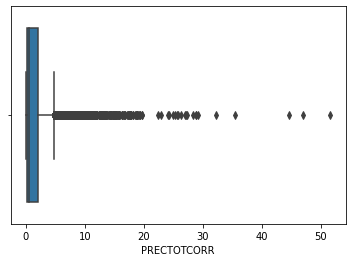

In [8]:
# Check for outliers
sns.boxplot(x=df['PRECTOTCORR'])

array([<AxesSubplot:xlabel='date'>, <AxesSubplot:xlabel='date'>,
       <AxesSubplot:xlabel='date'>, <AxesSubplot:xlabel='date'>,
       <AxesSubplot:xlabel='date'>], dtype=object)

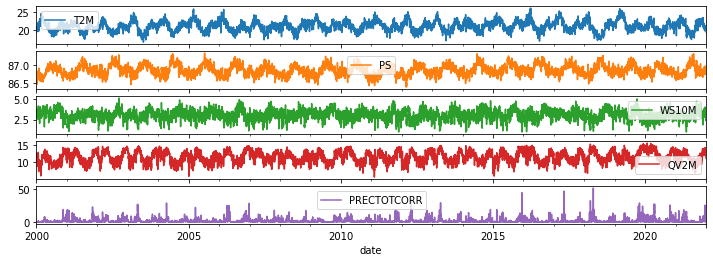

In [14]:
# Visualize trends
df.plot.line(figsize=(12, 4), subplots=True)
# plt.savefig("Sub plot", dpi=1200)

### Check for multicollinearity among predictor variables

In [34]:
correlation = df.iloc[:, :-1].corr()

<AxesSubplot:>

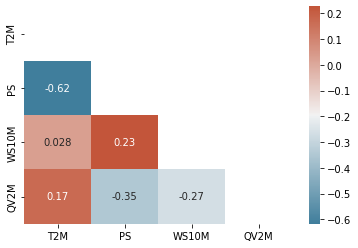

In [35]:
# Generate a mask for upper traingle
#
mask = triu(ones_like(correlation, dtype=bool))

cmap = sns.diverging_palette(230, 20, as_cmap=True)

sns.heatmap(correlation, annot=True, mask=mask, cmap=cmap)

In [39]:
# split multivariate sequence into samples
def to_supervised(sequences, n_steps_back, n_steps_future):
    X, y = list(), list()
    for i in range(len(sequences)):
        # find the end of the pattern
        end_index = i + n_steps_back
        out_end_index = end_index + n_steps_future - 1
        # check if index is out of bound
        if out_end_index > len(sequences) - 1:
            break
        # gather input and output parts of the pattern
        seq_x, seq_y = sequences[i:end_index, :-1], sequences[end_index-1:out_end_index, -1]
        X.append(seq_x)
        y.append(seq_y)
    return array(X), array(y)


In [49]:
# Normalization
scaler = MinMaxScaler(feature_range=(0,1))

df_scaled = scaler.fit_transform(df)

In [50]:
X, y = to_supervised(df_scaled,n_steps_back=60,n_steps_future=30)

In [51]:
print('Y shape', y.shape)
print('X shape', X.shape)
print('DF Scaled', df_scaled.shape)

Y shape (7948, 30)
X shape (7948, 60, 4)
DF Scaled (8037, 5)


In [52]:
x_train, x_test, y_train, y_test = train_test_split(X, y, test_size=0.20, random_state=0)

### Problem Framing
#### Given the past 28 days historical weather data, forecast the rainfall for the next 7 days

In [58]:
model = Sequential()
model.add(LSTM(64, activation='relu', input_shape=(x_train.shape[1], x_train.shape[2]), return_sequences=True))
model.add(LSTM(32, activation='relu', return_sequences=False, recurrent_dropout=0.2, unroll=True))
model.add(Dropout(0.2))
model.add(Dense(y_train.shape[1]))
model.compile(optimizer='adam', loss='mse')
model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_4 (LSTM)               (None, 60, 64)            17664     
                                                                 
 lstm_5 (LSTM)               (None, 32)                12416     
                                                                 
 dropout_2 (Dropout)         (None, 32)                0         
                                                                 
 dense_2 (Dense)             (None, 30)                990       
                                                                 
Total params: 31,070
Trainable params: 31,070
Non-trainable params: 0
_________________________________________________________________


In [59]:
history = model.fit(x_train, y_train, epochs=100, batch_size=28, validation_split=0.3, verbose=1)

Epoch 1/100
159/159 [==============================] - 37s 77ms/step - loss: 0.0035 - val_loss: 0.0032
Epoch 2/100
159/159 [==============================] - 9s 54ms/step - loss: 0.0033 - val_loss: 0.0032
Epoch 3/100
159/159 [==============================] - 9s 57ms/step - loss: 0.0032 - val_loss: 0.0031
Epoch 4/100
159/159 [==============================] - 8s 50ms/step - loss: 0.0031 - val_loss: 0.0030
Epoch 5/100
159/159 [==============================] - 8s 51ms/step - loss: 0.0031 - val_loss: 0.0030
Epoch 6/100
159/159 [==============================] - 8s 53ms/step - loss: 0.0031 - val_loss: 0.0030
Epoch 7/100
159/159 [==============================] - 9s 59ms/step - loss: 0.0030 - val_loss: 0.0030
Epoch 8/100
159/159 [==============================] - 9s 59ms/step - loss: 0.0030 - val_loss: 0.0030
Epoch 9/100
159/159 [==============================] - 9s 55ms/step - loss: 0.0030 - val_loss: 0.0030
Epoch 10/100
159/159 [==============================] - 8s 53ms/step - loss: 0.00

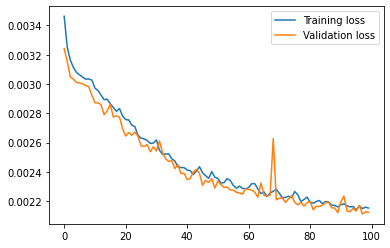

In [60]:
plt.plot(history.history['loss'], label='Training loss')
plt.plot(history.history['val_loss'], label='Validation loss')
plt.legend()

In [61]:
y_pred = model.predict(x_test, verbose=0)

In [62]:
from numpy import zeros

In [65]:
def reverse_y_scaler(data):
    data = data.ravel() # convert from 2D array into 1D array
    # create a new numpy array
    shape = (data.shape[0], 5)
    n_array = zeros(shape)
    n_array[:, -1] = data
    return n_array

In [66]:
# Does the scaler work in reverse
inv_yhat = scaler.inverse_transform(reverse_y_scaler(y_pred))[:, -1]
inv_ytest = scaler.inverse_transform(reverse_y_scaler(y_test))[:, -1]

## Evaluation Metric
<!-- Evaluate each time step separately in order to:
* Comment on the skill at a particular lead time (1 day vs 3 day)
* Contrast models based on their skills at different lead times (models good at +1 day vs models good at days +5)

Adopt an error metric that has the metric in (mm) similar to our target variable, rainfall.
Use Root Mean Square Error (RMSE), it has a higher punishment on forecast errors. -->

In [67]:
from numpy import sum
def mse_loss(y_pred, y_true):
    squared_error = (y_pred - y_true) ** 2
    sum_squared_error = sum(squared_error)
    loss = sum_squared_error / y_true.size
    return loss

In [68]:
mse = mse_loss(inv_yhat, inv_ytest)
print('Mean Squared Error', mse)

Mean Squared Error 5.701264785851449


In [69]:
root_mean_square = sqrt(mse)
print(root_mean_square)

2.3877321428190914


In [70]:
model.save('rainfall-model')

INFO:tensorflow:Assets written to: rainfall-model\assets


INFO:tensorflow:Assets written to: rainfall-model\assets


In [71]:
X[0].shape

(60, 4)

In [72]:
y_pred[0].shape

(30,)

In [73]:
y_test[0].shape

(30,)

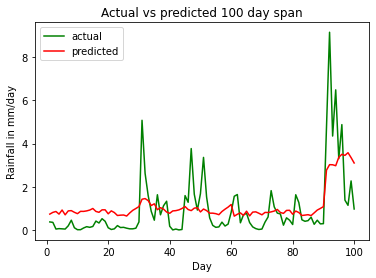

In [74]:
x_t = list(range(1,101))
plt.plot(x_t, inv_ytest[0:100], color='g', label='actual')
plt.plot(x_t, inv_yhat[0:100], color='r', label='predicted')
plt.title('Actual vs predicted 100 day span')
plt.xlabel('Day')
plt.ylabel('Rainfall in mm/day')
plt.legend()
plt.show()


In [75]:
df_scaled

array([[3.69978858e-01, 2.10526316e-01, 4.66981132e-01, 6.41509434e-01,
        7.74593338e-04],
       [4.01691332e-01, 1.78947368e-01, 4.85849057e-01, 7.03078451e-01,
        3.87296669e-03],
       [3.56236786e-01, 1.57894737e-01, 5.37735849e-01, 6.84210526e-01,
        8.32687839e-03],
       ...,
       [4.52431290e-01, 3.89473684e-01, 3.82075472e-01, 7.32869911e-01,
        1.60728118e-02],
       [3.89006342e-01, 4.31578947e-01, 4.36320755e-01, 6.11717974e-01,
        3.87296669e-04],
       [3.03382664e-01, 5.05263158e-01, 3.65566038e-01, 5.51142006e-01,
        0.00000000e+00]])

In [76]:
pickle.dump(scaler, open('scaler.sav', 'wb'))